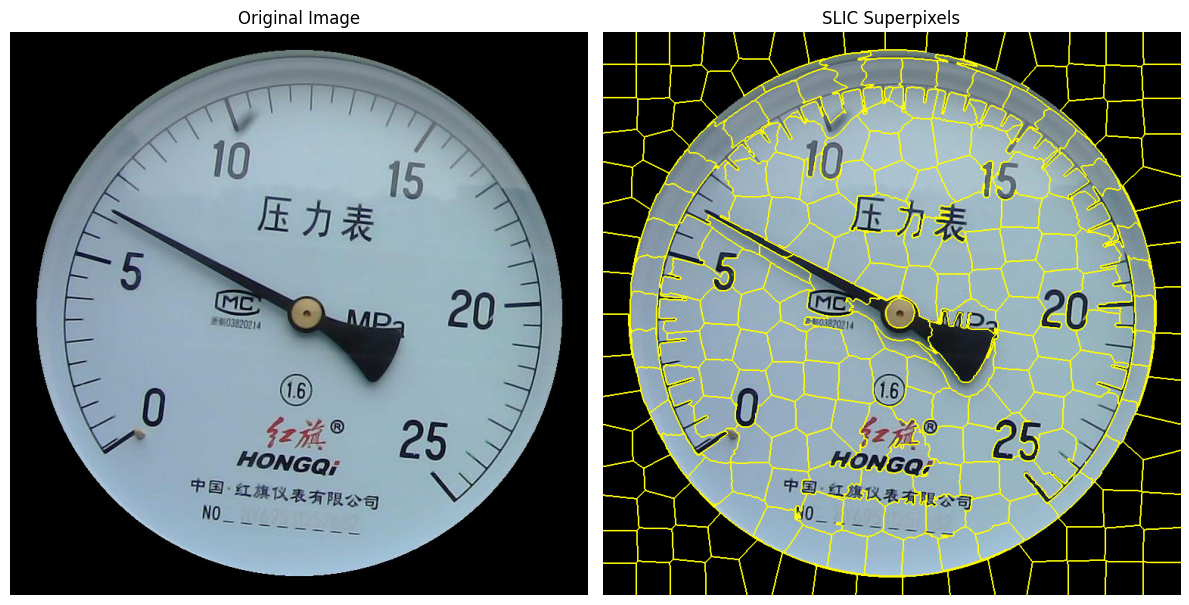

In [39]:
import numpy as np
import cv2  # 导入OpenCV库
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries

# 使用OpenCV加载图像（注意：OpenCV以BGR格式读取）
image_path = '../source/1.3/template.jpg'  # 替换为你的图片路径
image_bgr = cv2.imread(image_path)

K = 300

# 将图像从BGR转换为Lab颜色空间


# 使用SLIC算法进行超像素分割
image_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)
segments = slic(image_lab, n_segments=K, compactness=10, sigma=1)




# 绘制带有边界的图像
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# 将图像从BGR转换为RGB（因为matplotlib期望RGB格式）
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

ax[0].imshow(image_rgb)
ax[0].set_title('Original Image')
ax[0].axis('off')

# 将边界标记在原始图像上
ax[1].imshow(mark_boundaries(image_rgb, segments))
ax[1].set_title('SLIC Superpixels')
ax[1].axis('off')

plt.tight_layout()
plt.show()
plt.close()

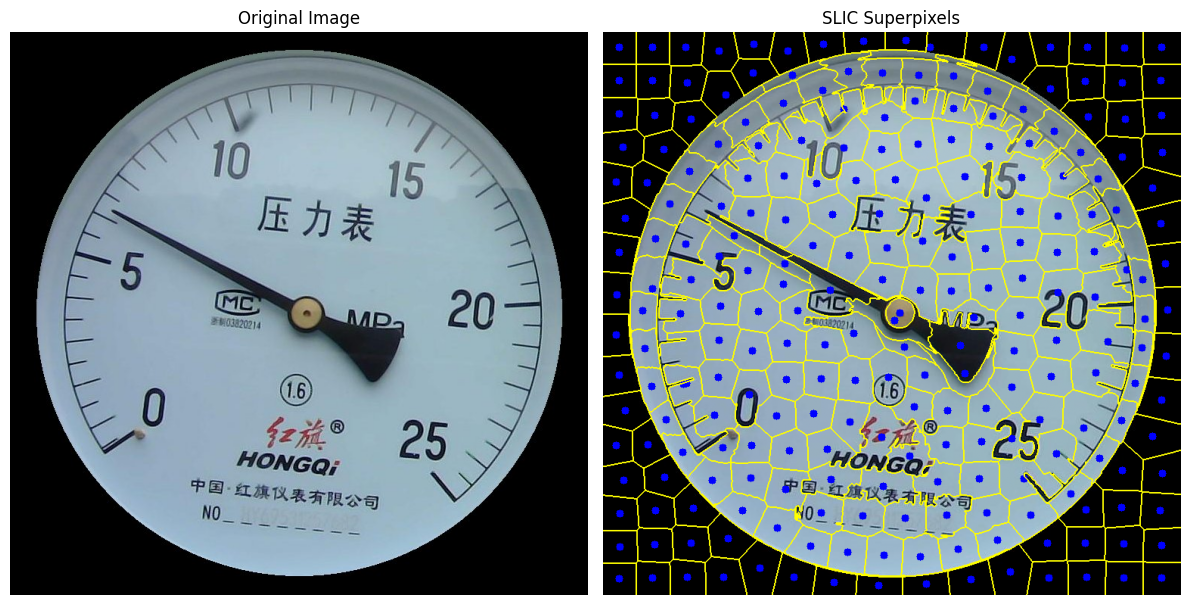

In [40]:
# 获取每个超像素区域的中心
def compute_superpixel_centers(segments):

    # 使用np.unique获取所有超像素标签
    unique_segments = np.unique(segments)
    # 计算每个超像素的中心坐标
    superpixel_centers = np.array([np.mean(np.column_stack(np.where(segments == segment_id)), axis=0)
                                   for segment_id in unique_segments])

    return superpixel_centers

# 调用函数
superpixel_centers = compute_superpixel_centers(segments)


# 使用Matplotlib显示图像
# 绘制带有边界的图像
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# 将图像从BGR转换为RGB（因为matplotlib期望RGB格式）
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

temp_img = image_rgb.copy()
# 在图像上标记超像素中心
for center in superpixel_centers:
    # 获取超像素中心的坐标
    x, y = int(center[0]), int(center[1])

    # 在中心绘制一个小圆圈
    cv2.circle(temp_img, (y, x), 5, (0, 0, 255), -1)  # 红色圆点，半径5

ax[0].imshow(image_rgb)
ax[0].set_title('Original Image')
ax[0].axis('off')

# 将边界标记在原始图像上
ax[1].imshow(mark_boundaries(temp_img, segments))
ax[1].set_title('SLIC Superpixels')
ax[1].axis('off')

plt.tight_layout()
plt.show()
plt.close()

In [41]:
def compute_superpixel_lab_means(segments, image_lab):

    # 获取所有唯一的超像素标签
    unique_segments = np.unique(segments)

    # 创建一个空的数组来存储每个超像素区域的 L*a*b 平均值
    lab_means = np.zeros((len(unique_segments), 3), dtype=np.float32)

    # 遍历每个超像素标签，计算其L*a*b区域的均值
    for i, segment_id in enumerate(unique_segments):
        # 获取当前超像素区域的掩码
        mask = (segments == segment_id)

        # 提取该超像素区域的所有 L*a*b 像素值
        lab_values = image_lab[mask]

        # 计算 L*a*b 平均值并存储
        lab_means[i] = np.mean(lab_values, axis=0)

    return lab_means

lab_means = compute_superpixel_lab_means(segments, image_lab)

In [42]:
def compute_chi(superpixel_centers, lab_means, image_shape):
    """
    计算每个超像素的 chi 值。

    参数:
        superpixel_centers (ndarray): 超像素中心的坐标，形状为 (num_superpixels, 2)。
        lab_means (ndarray): 每个超像素的 L*a*b 平均值，形状为 (num_superpixels, 3)。
        image_shape (tuple): 图像的形状 (height, width)。

    返回:
        chi_values (ndarray): 每个超像素的 chi 值，形状为 (num_superpixels,)。
    """
    # 获取图像中心的坐标
    h, w, _ = image_shape
    image_center = np.array([h / 2, w / 2])

    # 计算每个超像素到图像中心的距离 d_c(p_i)
    d_c = np.linalg.norm(superpixel_centers - image_center, axis=1)

    # 计算每个超像素之间的 L*a*b 距离 d_p(p_i, p_j)
    num_superpixels = superpixel_centers.shape[0]
    d_p_matrix = np.linalg.norm(lab_means[:, np.newaxis, :] - lab_means[np.newaxis, :, :], axis=2)

    # 初始化 chi 值数组
    chi_values = np.zeros(num_superpixels)

    # 计算 chi(p_i) 的值
    for i in range(num_superpixels):
        # 计算每个超像素的 chi(p_i)
        term1 = 1 / (1 + d_c[i])
        sum_term = np.sum((np.linalg.norm(superpixel_centers[i] - superpixel_centers, axis=1) /
                           (1 + d_p_matrix[i])))

        chi_values[i] = term1 * sum_term

    return chi_values

In [43]:
chi_values = compute_chi(superpixel_centers, lab_means, image_lab.shape)

# 输出 chi 值
print(chi_values)

chi_values_min = chi_values.min()
chi_values_max = chi_values.max()
chi_normalized = (chi_values - chi_values_min) / (chi_values_max - chi_values_min)

[ 80.03141967  81.84415758  84.2380306   87.40551049  89.85461916
  85.28626172  70.43320533  55.85563632  84.99459539   4.1898751
  86.67235607   6.15604134  90.70407502  87.533354    84.81112958
  82.60998782   7.52965866   8.45241     83.12274625   9.77034214
   9.25788218   5.64017701  91.29339135  81.55694226  83.9693903
  84.40177256  87.46150756  87.55283251   6.46094929  11.46661469
   4.52274174   9.52612115  10.63607204   9.84284971  14.36105394
  20.03844463  19.98800642  83.5878587   87.1089258   74.25890346
  18.28622298  86.65610709  16.34592108  61.27799564  90.76455878
  11.14889454  10.25055527  22.76739915  21.39764607  11.47954977
  11.65490225  10.11753299  20.87658507  13.32138102  17.93441979
  86.3976065   52.51541615  10.20673629  11.66918279  89.44122112
  19.3531923   10.49661452  18.58290284  20.76163024  21.92731601
  20.85660203  23.93724602  24.88685583  10.61052986  16.75017733
  14.60862231  43.61800976   7.22126738  88.27881881  90.70257489
  31.2891322

In [44]:
sp_values = 1 - np.exp(-chi_normalized)

print(sp_values)

[0.54620435 0.55469381 0.56566201 0.57976059 0.59034716 0.57037933
 0.49848172 0.41622977 0.56907192 0.         0.57653854 0.02027493
 0.59395641 0.58031991 0.56824749 0.55823248 0.03419514 0.04343505
 0.56058605 0.05647899 0.0514283  0.01499551 0.59644165 0.55335938
 0.56444474 0.56640229 0.58000567 0.58040507 0.02338209 0.07300603
 0.00346176 0.05407537 0.06495042 0.05719144 0.1005413  0.15219831
 0.15175271 0.56271007 0.57846013 0.51807698 0.13658005 0.57646685
 0.11894943 0.44829253 0.59421218 0.06993262 0.06118746 0.17596186
 0.16411859 0.07313094 0.0748226  0.05988554 0.1595688  0.09074614
 0.13340977 0.57532473 0.39555814 0.06075879 0.07496023 0.5885791
 0.14612431 0.06359094 0.13924457 0.1585617  0.16871832 0.15939382
 0.18594373 0.19395742 0.06470157 0.12265217 0.10285814 0.33685238
 0.03108723 0.58356659 0.59395006 0.24596529 0.14707878 0.02913334
 0.07089324 0.15808413 0.11237972 0.16382915 0.27107869 0.17160841
 0.19150774 0.23895285 0.16690269 0.58870204 0.35004828 0.05103

In [45]:
pixel_value = (sp_values * 255).astype(np.uint8)


In [46]:
def set_pixel_values_by_superpixel(segments, sp_values):
    """
    根据超像素标签图 segments 和对应的 S_p(p_i) 值设置图像的像素值。

    参数:
        segments (ndarray): 超像素标签图，形状为 (h, w)。
        sp_values (ndarray): 每个超像素的 S_p(p_i) 值，形状为 (num_superpixels,)。

    返回:
        pixel_image (ndarray): 设置了像素值的新图像，形状为 (h, w)，像素值范围 [0, 255]。
    """
    # 创建一个与图像大小相同的数组，用于存储像素值
    h, w = segments.shape
    pixel_image = np.zeros((h, w), dtype=np.uint8)

    # 遍历每个超像素区域并将像素值设置为对应的 S_p(p_i)
    for i, sp_value in enumerate(sp_values):
        # 设置所有属于超像素 i 的像素值为 S_p(p_i) * 255
        pixel_image[segments == i] = (sp_value * 255).astype(np.uint8)

    return pixel_image

In [47]:
pixel_image = set_pixel_values_by_superpixel(segments, sp_values)

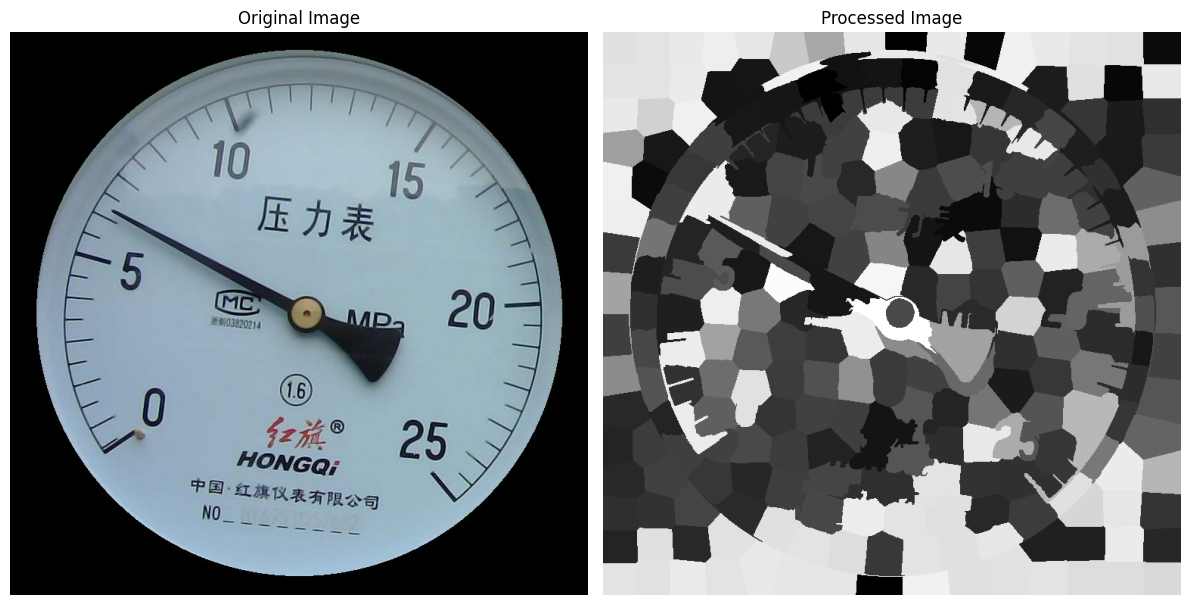

In [48]:
# 将图像从BGR转换为RGB（因为matplotlib期望RGB格式）
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# 创建 matplotlib 的 subplots，显示原始图像和处理后的图像（例如 pixel_image）
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 在第一个子图中展示原始图像
ax[0].imshow(image_rgb)
ax[0].set_title('Original Image')
ax[0].axis('off')  # 关闭坐标轴

# 在第二个子图中展示处理后的图像（例如 pixel_image）
ax[1].imshow(pixel_image, cmap='gray')  # 使用灰度模式显示处理后的图像
ax[1].set_title('Processed Image')  # 可以根据需要更改标题
ax[1].axis('off')  # 关闭坐标轴

# 调整布局并显示图像
plt.tight_layout()
plt.show()
plt.close()